# Practical - Predicting with modern CNN architecture


## Tensorflow API
The TensorFlow Object Detection API is an open-source framework built on top of TensorFlow that makes it easy to construct, train and deploy object detection models. There are already pre-trained models in their framework which are referred to as Model Zoo. More info about the Tensorflow API (https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html).


####  Installing the TensorFlow API

This can be a bit tricky. We will begin by installing packages. Those which are not already present in the Jupyter environment using the !pip command. If you get an error for pip installation. Try adding *--user* to the end of each line.

In [1]:
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim
!pip install pycocotools
!pip install seaborn 
!pip install geopandas 

  Using cached tensorflow-2.20.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow-2.20.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
Using cached tensorflow-2.20.0-cp39-cp39-macosx_12_0_arm64.whl (200.4 MB)
Using cached tensorflow-2.20.0-cp39-cp39-macosx_12_0_arm64.whl (200.4 MB)
Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)
Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow━━━━━━━━━━━━━━ 0/2 [tensorboard]
    Found exist

Get tensorflow/models by cloning the tensorflow/models github repository:

In [2]:
## clone the tensorflow models github repository
import pathlib
import os
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4373, done.
remote: Counting objects: 100% (4373/4373), done.
remote: Enumerating objects: 4373, done.[K
remote: Counting objects: 100% (4373/4373), done.
remote: Compressing objects: 100% (3184/3184), done.
remote: Compressing objects: 100% (3184/3184), done.
remote: Total 4373 (delta 1185), reused 3069 (delta 1115), pack-reused 0 (from 0)
Receiving objects: 100% (4373/4373), 70.01 MiB | 44.06 MiB/s, done.
Resolving deltas: 100% (1185/1185), done.
remote: Total 4373 (delta 1185), reused 3069 (delta 1115), pack-reused 0 (from 0)
Receiving objects: 100% (4373/4373), 70.01 MiB | 44.06 MiB/s, done.
Resolving deltas: 100% (1185/1185), done.


#### !! Do these lines in your terminal

In order to successfully install the object detection API, you will need to open a bash terminal. Make sure to run the ```%bash``` parts of the code in the terminal. Installation will take a few minutes:

In [ ]:
%%bash
# cd material/models/research/
# protoc object_detection/protos/*.proto --python_out=.
# cp object_detection/packages/tf2/setup.py .
# python -m pip install .
# pip uninstall protobuf
# pip install protobuf


To load the object detection utils, change into the models/research directory which we cloned from github above (your path might be different to adjust as necessary):

In [2]:
import os
print (os.getcwd())
os.chdir('models/research')
print (os.getcwd())

/Users/ayouba/Documents/laboratoire/FYC/material
/Users/ayouba/Documents/laboratoire/FYC/material/models/research


In [ ]:
# change back to the root directory afterwards
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
os.chdir('../..')
print (os.getcwd())

Great we now have access to TensorFlow Object Detection API where we will load the Object Detection model from.


## Object detection

In this section, we will introduce the object detection architecture, install the Tensorflow Object Detection API, load the model and run inference on the dataset.

#### Choosing a model architecture: MobileNet-SSD
The two stage Object Detection algorithm named Faster R-CNN is made up of the region proposal network (RPN) and the detection network. This architecture continues to feature in some of the top performing networks (see https://paperswithcode.com/sota/object-detection-on-coco). 

However, in the interest of processing time and memory, we chose the <b>MobileNet-SSD for the tutorial</b>. 

Depending on your time/accuracy trade-off, you can choose the appropriate model from the TensorFlow API. If we want a high-speed model the single-shot detection (SSD) network works best. As its name suggests, the SSD network determines all bounding box probabilities in one go; hence, it is much faster than the two stage R-CNN.
The SSD architecture is a single convolution network that learns to predict bounding box locations and classify these locations in one pass. Hence, SSD can be trained end-to-end. The SSD network consists of a base architecture (MobileNet in this case) followed by several convolution layers:

![alt text](images/mobileNet-SSD-network-architecture.png)

The SSD's operates on feature maps to detect the location of bounding boxes. Recall – a feature map is of the size Df * Df * M. For each feature map location, k bounding boxes are predicted. Each bounding box carries with it the following information:
 - 4 corner bounding box offset locations (cx, cy, w, h)
 - C class probabilities (c1, c2, …cp)
 
SSD does not predict the shape of the box, rather just where the box is. The k bounding boxes each have a predetermined shape. The shapes are set prior to actual training. For example, in the figure above, there are 5 boxes, meaning k=5.

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time

from matplotlib import pyplot as plt
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warning

In [5]:
%matplotlib inline

#### Load Model

Since we have successfully downloaded the Object Detection API, we will load the SSD MobileNet model.

The code snippet shown below is used to download the pre-trained object detection model we shall use to perform inference. The particular detection algorithm we will use is the SSD mobilenet 640x640. More models can be found in the TensorFlow Object Detection Model Zoo (https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md):

In [6]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

Next, we download the labels file (.pbtxt). This contains a list of strings used to add the correct label to each detection (e.g. person). Since the pre-trained model we will use has been trained on the COCO dataset, we will need to download the labels file corresponding to this dataset, named mscoco_label_map.pbtxt:

In [9]:
# Download labels file
import pathlib
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

Next we load the model:

In [10]:
import os

# Verify the model directory exists and find the correct saved_model path
print(f"Model directory: {PATH_TO_MODEL_DIR}")

if os.path.exists(PATH_TO_MODEL_DIR):
    # Check for nested model directory structure (common with TensorFlow model downloads)
    nested_model_dir = os.path.join(PATH_TO_MODEL_DIR, MODEL_NAME)
    if os.path.exists(nested_model_dir):
        PATH_TO_MODEL_DIR = nested_model_dir
        print(f"Using nested model directory: {MODEL_NAME}")
    
    # Set path to saved_model directory
    PATH_TO_SAVED_MODEL = os.path.join(PATH_TO_MODEL_DIR, "saved_model")
    
    # Verify saved_model exists, re-download if necessary
    if not os.path.exists(PATH_TO_SAVED_MODEL):
        if os.path.exists(os.path.join(PATH_TO_MODEL_DIR, "saved_model.pb")):
            PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR
        else:
            print("Saved model not found. Re-downloading...")
            PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)
            nested_model_dir = os.path.join(PATH_TO_MODEL_DIR, MODEL_NAME)
            if os.path.exists(nested_model_dir):
                PATH_TO_MODEL_DIR = nested_model_dir
            PATH_TO_SAVED_MODEL = os.path.join(PATH_TO_MODEL_DIR, "saved_model")
else:
    print("Model directory doesn't exist. Downloading...")
    PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)
    nested_model_dir = os.path.join(PATH_TO_MODEL_DIR, MODEL_NAME)
    if os.path.exists(nested_model_dir):
        PATH_TO_MODEL_DIR = nested_model_dir
    PATH_TO_SAVED_MODEL = os.path.join(PATH_TO_MODEL_DIR, "saved_model")

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Took {elapsed_time:.2f} seconds')

Model directory: /Users/ayouba/.keras/datasets/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8
Using nested model directory: ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8
Loading model...Done! Took 3.32 seconds
Done! Took 3.32 seconds


#### Load label map data (for plotting)
Label maps join numerical indices to category names, so that when the CNN predicts 5, we know that this corresponds to the object: airplane. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

#### Running Inference on the Image Dataset
The code shown below loads an image, runs it through the detection model and visualizes the detection results, including the keypoints.

Note that this will take a long time (several minutes) the first time you run this code due to tf.function’s trace-compilation — on subsequent runs (e.g. on new images), things will be faster.

Print out detections[‘detection_boxes’] and try to match the box locations to the boxes in the image. Notice that coordinates are given in normalized form (i.e., in the interval [0, 1]).

Set min_score_thresh to other values (between 0 and 1) to allow more detections in or to filter out more detections.


Extract [Here](https://drive.google.com/file/d/1Uj-3s-5YAqGw0IIJTV9bwS6IYbf6CJxl/view?usp=sharing) the dataset used and put it in `input/`folder.

In [12]:
img_folder = '../input/places365standard_easyformat/places365_standard/val/'

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

def run_inference_for_single_image(model, image):
    
    image = load_image_into_numpy_array(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    #model_fn = model.signatures['serving_default']
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return image, output_dict

Let's visualise inference on just 5 of the images:

Running inference for ../input/places365standard_easyformat/places365_standard/val/highway/Places365_val_00034775.jpg... Done
Running inference for ../input/places365standard_easyformat/places365_standard/val/highway/Places365_val_00024604.jpg... Done
Running inference for ../input/places365standard_easyformat/places365_standard/val/highway/Places365_val_00025241.jpg... Done
Running inference for ../input/places365standard_easyformat/places365_standard/val/highway/Places365_val_00012770.jpg... Done
Running inference for ../input/places365standard_easyformat/places365_standard/val/highway/Places365_val_00024604.jpg... Done
Running inference for ../input/places365standard_easyformat/places365_standard/val/highway/Places365_val_00025241.jpg... Done
Running inference for ../input/places365standard_easyformat/places365_standard/val/highway/Places365_val_00012770.jpg... Done
Running inference for ../input/places365standard_easyformat/places365_standard/val/highway/Places365_val_00030114.jpg.

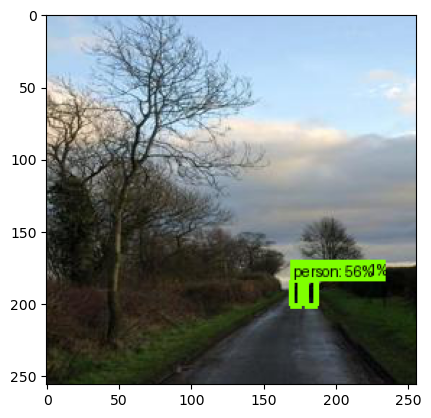

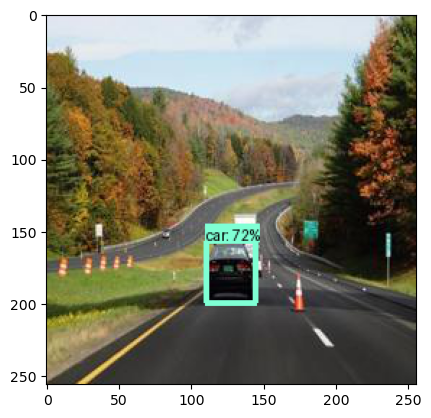

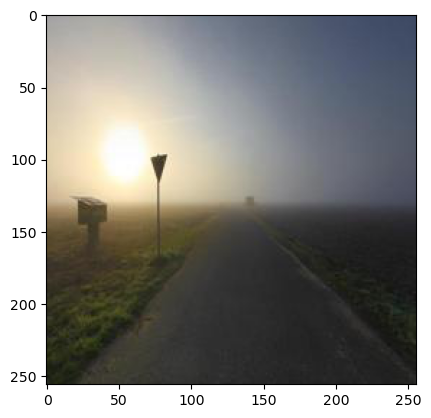

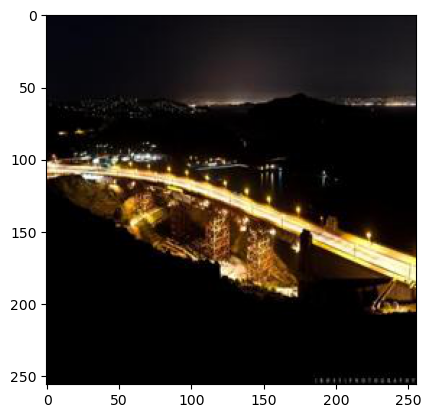

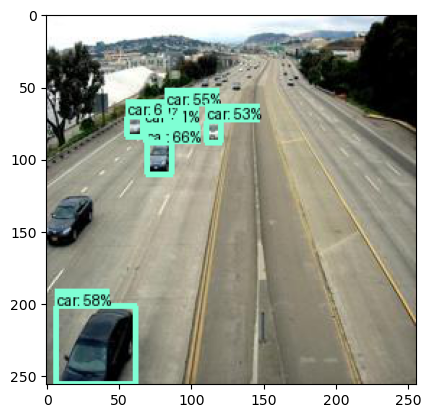

In [13]:
from pathlib import Path
i = 0
for image_path in Path(img_folder).rglob('*.jpg'):
    print('Running inference for {}... '.format(image_path), end='')
    
    # RUN INFERENCE
    image_np, detections = run_inference_for_single_image(detect_fn, image_path)
    
    # Visualise Detection
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.50,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
    i += 1
    if i == 5:
        break
plt.show()

#sphinx_gallery_thumbnail_number = 2

The Tensorflow API saves the results the in the detection object that contains multiple dictionaries:

In [14]:
for i in detections:
    print (i)

detection_scores
raw_detection_scores
detection_anchor_indices
raw_detection_boxes
detection_classes
detection_boxes
detection_multiclass_scores
num_detections


Now we will run inference on the entire dataset, storing the detection results in a dictionary:

In [15]:
def run_on_all_images(img_folder='../input/places365standard_easyformat/places365_standard/val/'):
    output_dicts = []
    images = Path(img_folder).rglob('*.jpg')
    corrupts = []
    for ix, image in enumerate(images):
        try:
            im, output_dict = run_inference_for_single_image(detect_fn, image)
        #print (images[ix])
            output_dicts.append(output_dict)
        except:
            corrupts.append(image)
        print ('Run inference on image %s' % ix)
    return output_dicts, corrupts

In [16]:
%%capture
import time
start_time = time.time()
det, corrupts = run_on_all_images(img_folder)
end_time = time.time()
print ('Takes %s seconds to run' % str(end_time - start_time))

#### Converting detected objects into DataFrame
We will make the data more manageable for subsequent analysis

In [17]:
from pathlib import Path
import os
import pandas as pd

detect_scores = []
detect_classes = []
detect_ymin = []
detect_xmin = []
detect_ymax = []
detect_xmax = []
Id_list = []

images = Path(img_folder).rglob('*.jpg')

for img, output_dict in zip(images, det):
    cut_off_scores = len(list(filter(lambda x: x >= 0.5, output_dict['detection_scores'])))
    detect_score = []
    detect_class = []
    for j in range(cut_off_scores):
        detect_score.append(output_dict['detection_scores'][j])
        detect_class.append(output_dict['detection_classes'][j])
    detect_scores.append(detect_score)
    detect_classes.append(detect_class)
    fname = os.path.basename(img)
    Id_list.append(fname)
    #Id_list.append()
Detected_objects = pd.DataFrame(
        {'Image': Id_list,
         'Score': detect_scores,
         'Class': detect_classes})

In [18]:
Detected_objects.head()

,Image,Score,Class
0,Places365_val_00034775.jpg,"[0.6090955, 0.5604635]","[1, 1]"
1,Places365_val_00024604.jpg,[0.7241555],[3]
2,Places365_val_00025241.jpg,[],[]
3,Places365_val_00012770.jpg,[],[]
4,Places365_val_00030114.jpg,"[0.66244006, 0.61193705, 0.59908223, 0.5785684...","[3, 3, 3, 3, 3, 3]"


In [19]:
Detected_objects.shape

(998, 3)

In [20]:
## Create a dictionary with the labels from the COCO dataset
coco_dict = category_index.values()
coco = pd.DataFrame(coco_dict)
coco = pd.Series(coco.name.values,index=coco.id).to_dict()

### Analysis of Results
Let's perform some analysis to find out more about the features extracted from the model.

We will first create a function to plot total object counts:

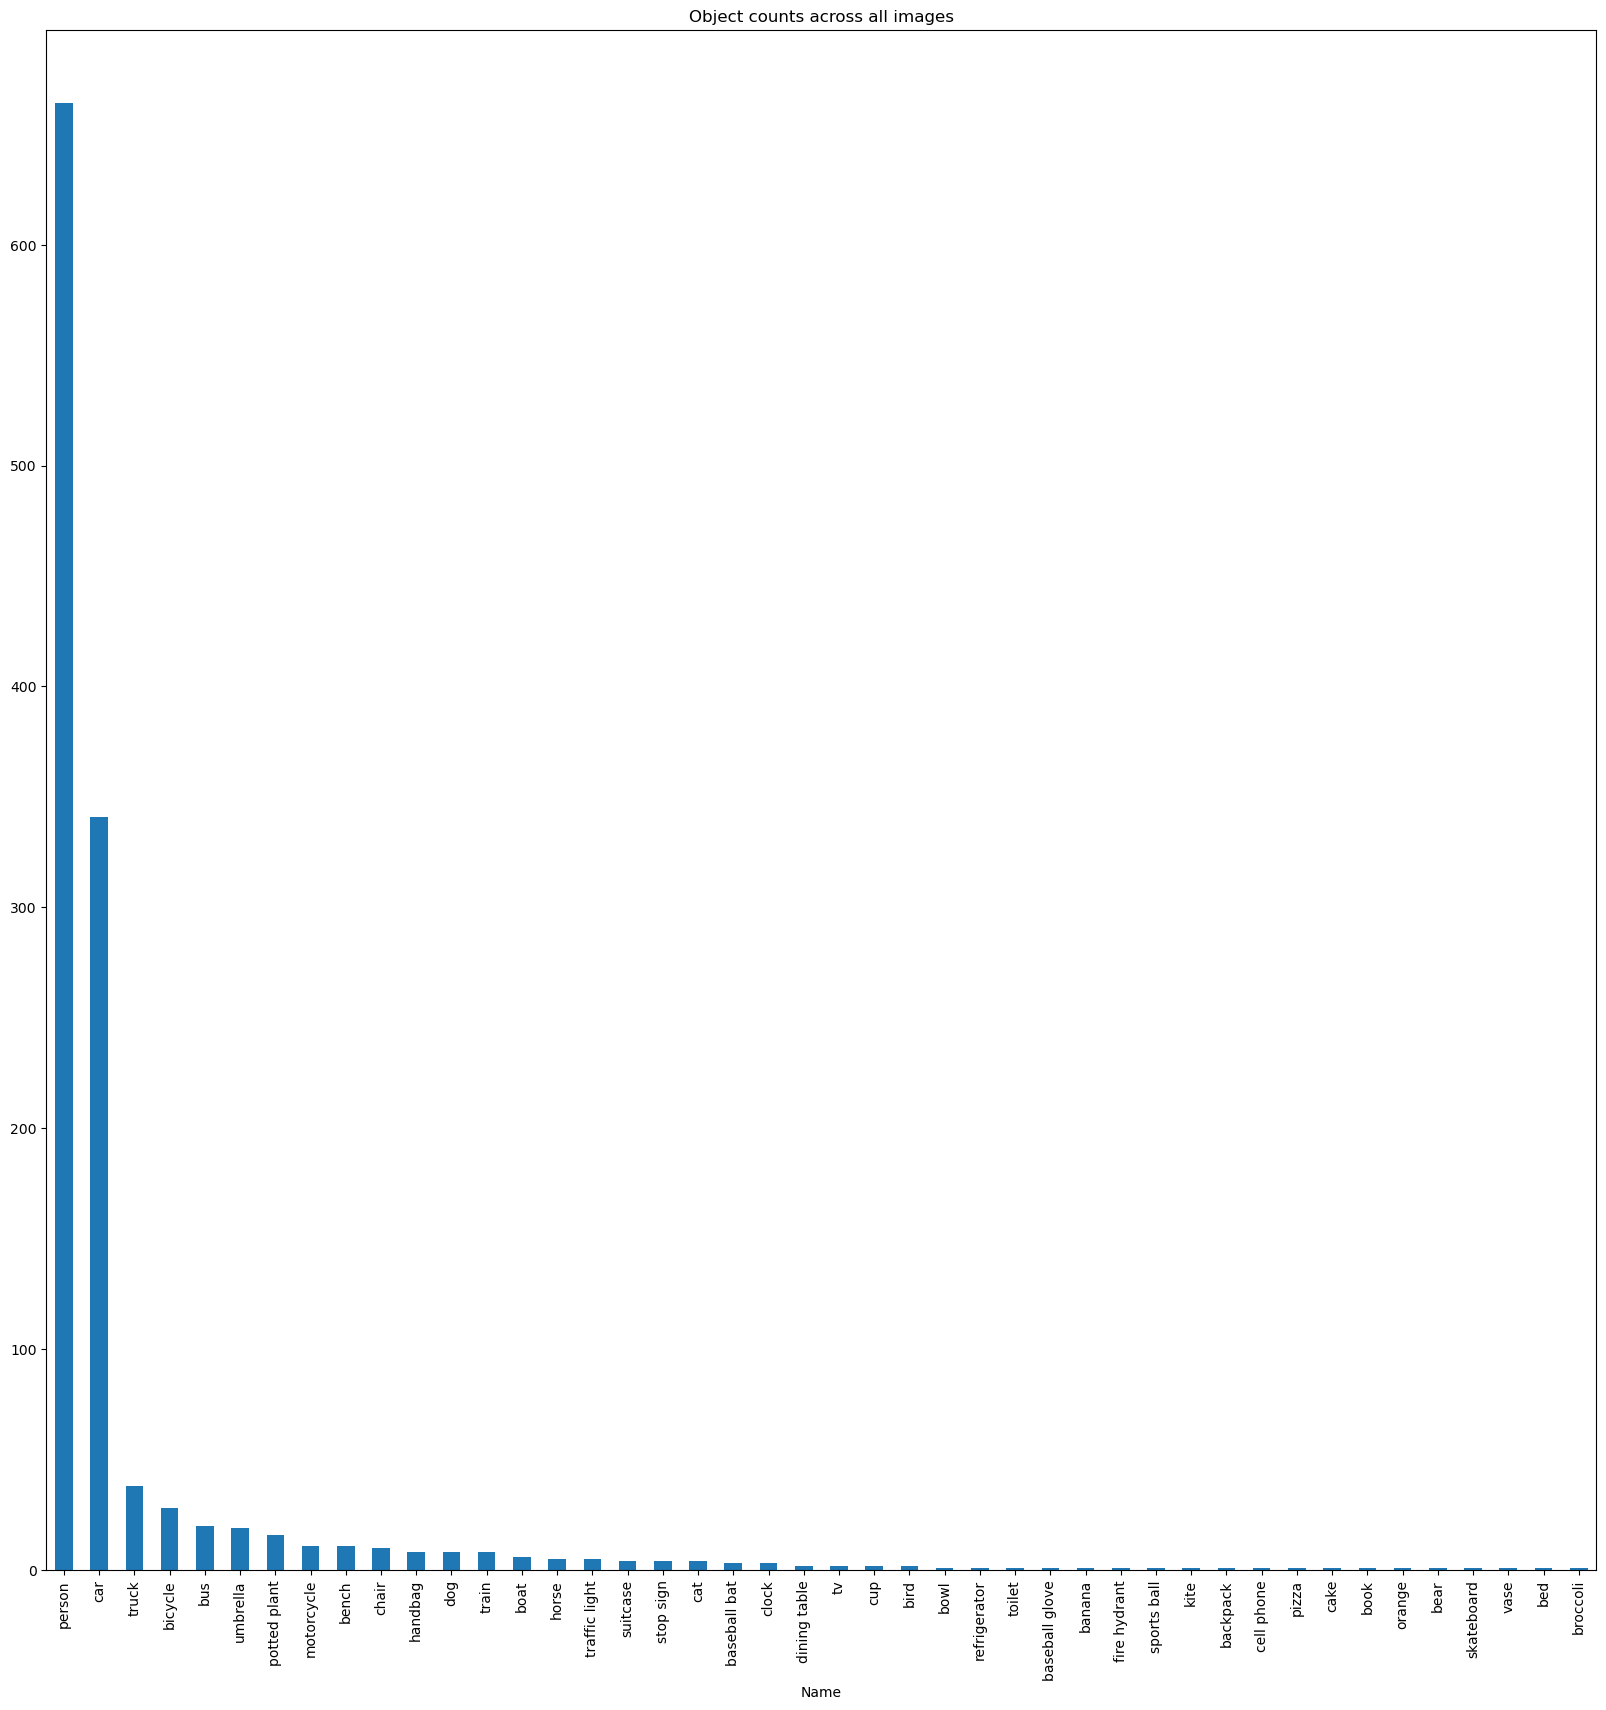

In [21]:
# Create a row for each Class element
lst_col = 'Class'
df = pd.DataFrame({
      col:np.repeat(Detected_objects[col].values, Detected_objects[lst_col].str.len())
      for col in Detected_objects.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(Detected_objects[lst_col].values)})[Detected_objects.columns]
df = df.drop('Score', axis = 1)

# Maps class integer to object name
df['Name'] = df['Class'].astype(int)
df['Name'] = df['Name'].map(coco)      

# plot total counts across all images
df['Name'].value_counts().plot.bar(figsize=(20,20))
plt.title('Object counts across all images')
plt.show()